# actiCHamp EEG data analysis from raw

reference about work flow: https://martinos.org/mne/stable/manual/cookbook.html

### Data
EEG with eyes-open / eyes-closed resting conditions were recorded via actiCHamp, BrainVision and PyCorder.  
1 subject x 50 samples x 2 conditions

In [1]:
import numpy as np
import pandas as pd
import sys, os, logging, datetime
from glob2 import glob
from tqdm import tqdm
from scipy import linalg

import mne
from mne import io
from mne.connectivity import spectral_connectivity
from mne.decoding import CSP
from mne.datasets import sample
from mne import *

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams

# set default fig size
mpl.style.use('classic')
mpl.rcParams['figure.figsize'] = [15.0, 10.0]
mpl.rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = 15, 10

%matplotlib inline

---

# I/O and Preprocessing


### loading

set `.vhdr` file path to the env variable in advance.

load eeg raw data `eeg`, and meta info `.vhdr`, `.vmrk` -> `RawBrainVision` instance.

Reader for Brain Vision EEG file.


```python

mne.io.read_raw_brainvision(vhdr_fname, montage=None, eog=('HEOGL', 'HEOGR', 'VEOGb'),
                            misc='auto', scale=1.0, preload=False, response_trig_shift=0,
                            event_id=None, trig_shift_by_type=None, stim_channel=None,
                            verbose=None)[source]
```

In [6]:
PATH = os.environ["SAMPLEPATH"]

raw = mne.io.read_raw_brainvision(PATH, preload=True)

Extracting parameters from /mnt/analysis/Group_Research/audio/2019a/rawdata/sample/20190428_kubota.vhdr...
Setting channel info structure...
Reading 0 ... 904999  =      0.000 ...   904.999 secs...


<ipython-input-6-e18af1613d72>:5: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  raw = mne.io.read_raw_brainvision(PATH, preload=True)


Used Annotations descriptions: ['Response/R  1', 'Response/R 15', 'Response/R  6', 'Response/R 14', 'Response/R  2']


### check meta information

In [7]:
raw.info

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, ...
    chs : list | 65 items (EEG: 64, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 500.0 Hz
    meas_date : tuple | 2019-04-28 13:50:56 GMT
    nchan : int | 65
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 1000.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplotter_la

### set Locations

set a montage type (`str`) which corresponds to used cap

In [8]:
montage = mne.channels.read_montage(kind="easycap-M1")

print(montage.ch_names)

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'F1', 'F2', 'FC1', 'FC2', 'C1', 'C2', 'CP1', 'CP2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'FC5', 'FC6', 'C5', 'C6', 'CP5', 'CP6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'F9', 'F10', 'FT9', 'FT10', 'TP9', 'TP10', 'P9', 'P10', 'PO9', 'PO10', 'O9', 'O10', 'Fpz', 'AFz', 'FCz', 'CPz', 'POz', 'Oz', 'Iz']


set to `Raw` object

In [9]:
raw.set_montage(montage)

<ipython-input-9-fe790fd59c77>:1: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['EOG', 'EOG2']. Their position has been left untouched.
  raw.set_montage(montage)


<RawBrainVision  |  20190428_kubota.eeg, n_channels x n_times : 65 x 905000 (905.0 sec), ~449.0 MB, data loaded>

### remove EOGs from EEG chs

In [10]:
raw.set_channel_types({"EOG":"eog", "EOG2":"eog", "STI 014":"stim"})

### plotting location

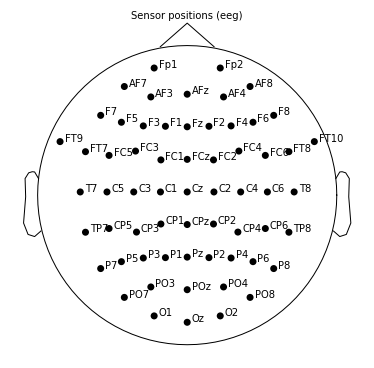

In [11]:
rcParams['figure.figsize'] = 5, 3

raw.plot_sensors("topomap", show_names=True)

None

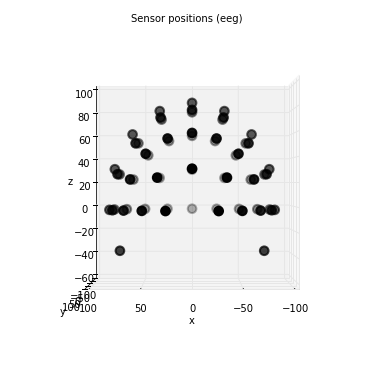

In [12]:
raw.plot_sensors("3d")

None

### Note: can handle data as `pandas.DataFrame` instance

In [13]:
raw.to_data_frame().head()

Converting time column to int64...


signal,Fp1,Fz,F3,F7,FT9,FC5,FC1,C3,T7,CP5,...,C2,FC4,FT8,F6,F2,AF4,AF8,EOG,EOG2,STI 014
time,,,,,,,,,,,,,,,,,,,,,
0,7500.439453,10813.867188,-5109.326172,-12581.005859,-1459.619141,12151.953125,2648.535156,767.138672,-14767.236328,-1070.068359,...,7295.654297,14335.644531,7663.574219,-11591.113281,14298.339844,8545.654297,-6275.488281,904678.3750,915990.1875,0.0
1,7500.366211,10808.911133,-5114.233398,-12586.499023,-1459.741211,12150.268555,2646.069336,764.526367,-14773.803711,-1073.461914,...,7291.333008,14331.616211,7659.643555,-11595.874023,14294.165039,8542.553711,-6281.567383,906712.4375,918667.3125,0.0
2,7506.079102,10808.569336,-5111.694336,-12593.920898,-1453.540039,12153.100586,2645.776367,765.893555,-14772.436523,-1072.241211,...,7290.649414,14331.665039,7661.254883,-11595.239258,14295.776367,8543.676758,-6282.104492,913566.0625,925196.6875,0.0
3,7512.939453,10812.890625,-5107.568359,-12587.451172,-1445.458984,12158.251953,2647.460938,767.089844,-14768.261719,-1069.482422,...,7292.089844,14331.738281,7660.888672,-11591.992187,14298.632812,8546.630859,-6279.785156,918421.1250,932414.2500,0.0
4,7515.527344,10811.230469,-5107.910156,-12585.107422,-1441.455078,12156.396484,2646.875000,764.208984,-14770.507812,-1072.558594,...,7287.597656,14326.611328,7659.277344,-11593.505859,14295.214844,8545.458984,-6277.539062,920472.7500,948185.3125,0.0


### Filtering

```python
raw.filter(l_freq, h_freq, picks=None, filter_length='auto', l_trans_bandwidth='auto',
           h_trans_bandwidth='auto', n_jobs=1, method='fir', iir_params=None, phase='zero',
           fir_window='hamming', fir_design='firwin',
           skip_by_annotation=('edge', 'bad_acq_skip'),
           pad='reflect_limited', verbose=None)
```

In [14]:
raw.filter(1., 40., n_jobs=1, fir_design='firwin')

Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 3301 samples (3.301 sec) selected


/home/atsuya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


<RawBrainVision  |  20190428_kubota.eeg, n_channels x n_times : 65 x 905000 (905.0 sec), ~449.0 MB, data loaded>

### ICA: Independent Component Analysis

In [15]:
from mne.preprocessing import ICA
from mne.preprocessing import create_eog_epochs, create_ecg_epochs

method = 'fastica'

# Choose other parameters
n_components = 25  # if float, select n_components by explained variance of PCA
decim = 3  # we need sufficient statistics, not all time points -> saves time

# we will also set state of the random number generator - ICA is a
# non-deterministic algorithm, but we want to have the same decomposition
# and the same order of components each time this tutorial is run
random_state = 23

# pick the channels which type is EEG
picks_eeg = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, 
                           stim=False, exclude='bads')

# instantiate model
ica = ICA(n_components=n_components, method=method, random_state=random_state)

In [16]:
%%time

ica.fit(raw, picks=picks_eeg, decim=decim, verbose=0)

CPU times: user 1min 21s, sys: 10.5 s, total: 1min 32s
Wall time: 5.88 s


<ICA  |  raw data decomposition, fit (fastica): 301667 samples, 25 components, channels used: "eeg">

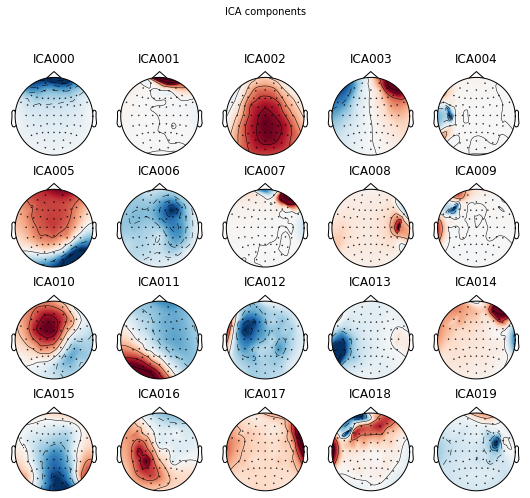

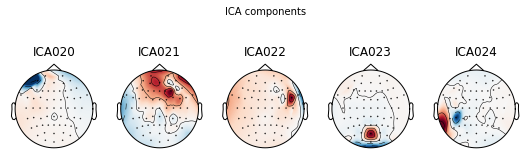

[<Figure size 540x504 with 20 Axes>, <Figure size 540x180 with 5 Axes>]

In [17]:
ica.plot_components()

In [18]:
ica.info

<Info | 17 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, ...
    chs : list | 62 items (EEG: 62)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 62 items
    events : list | 0 items
    highpass : float | 1.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 40.0 Hz
    meas_date : tuple | 2019-04-28 13:50:56 GMT
    nchan : int | 62
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 1000.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplotter_layou

# Visualize Raw data

[Documentation](https://martinos.org/mne/dev/auto_tutorials/plot_visualize_raw.html)

```python
raw.plot(events=None, duration=10.0, start=0.0, n_channels=20, bgcolor='w', color=None,
         bad_color=(0.8, 0.8, 0.8), event_color='cyan', scalings=None, remove_dc=True,
         order=None, show_options=False, title=None, show=True, block=False, highpass=None,
         lowpass=None, filtorder=4, clipping=None, show_first_samp=False, proj=True,
         group_by='type', butterfly=False, decim='auto', noise_cov=None, event_id=None)

```

In [20]:
events = mne.find_events(raw)

124 events found
Event IDs: [ 1  2  6 14 15]


first event

#### plot raw signals to look over the whole recorded EEG.

- view points
    - cyan lines are events
    - for detecting noisy channels, set 10x scaling value (default: 20e-6 -> 20e-5)

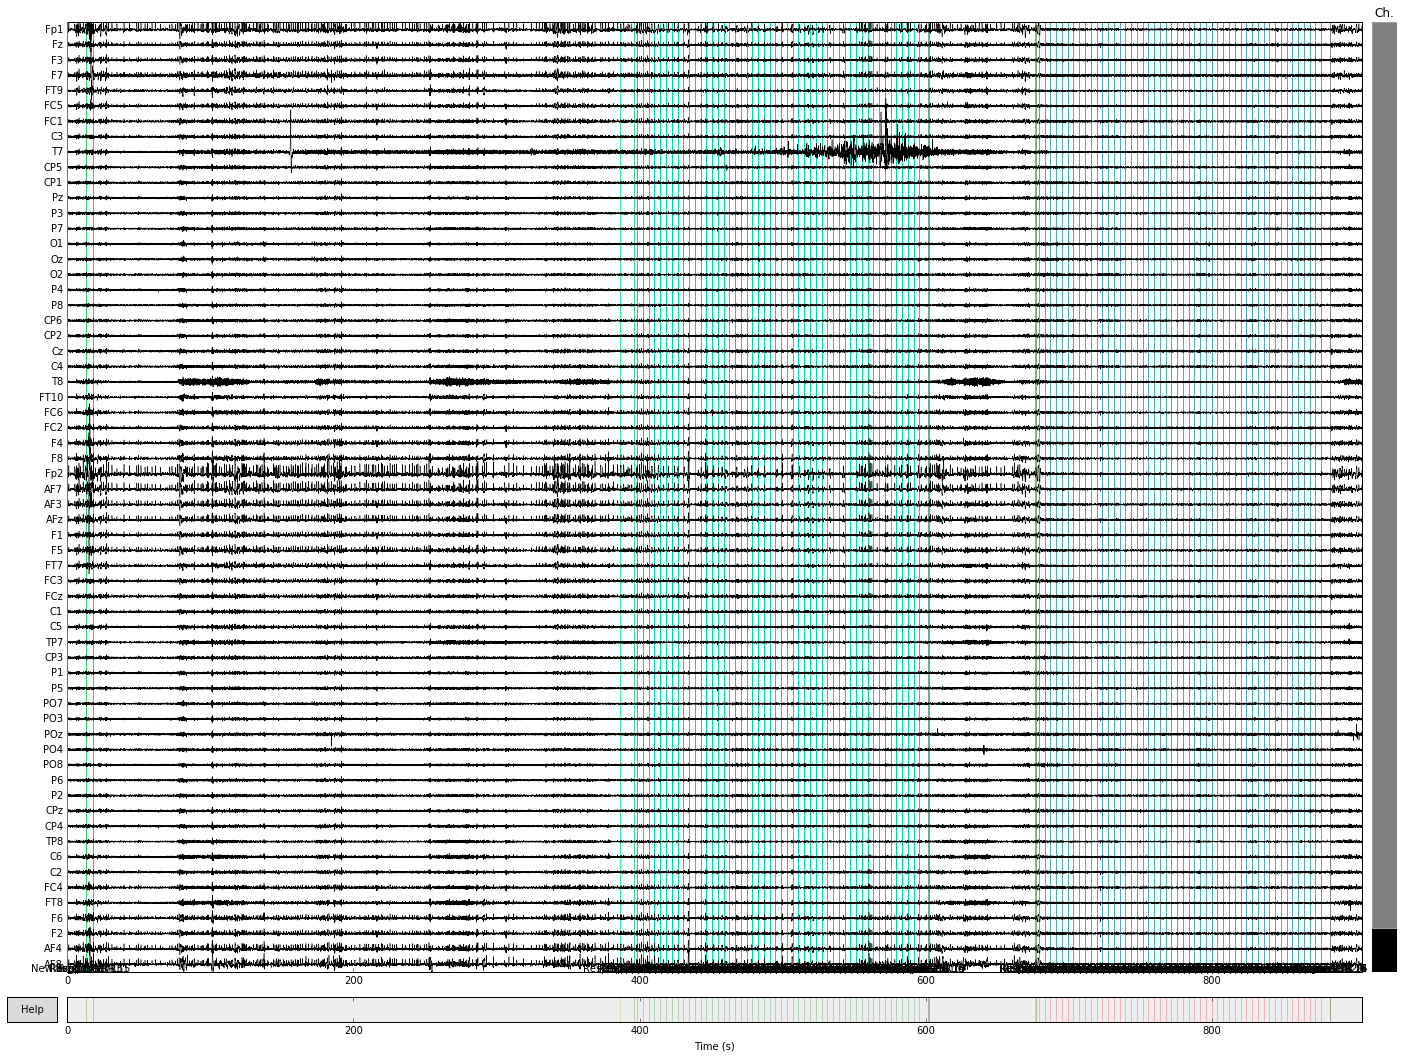

In [32]:
rcParams['figure.figsize'] = 20, 15  # fig size (inches)

raw.plot(events=events, block=True, duration=904999, n_channels=62,
         highpass=1, lowpass=40, scalings={"eeg":20e-5, "eog":150e-6})

None

# Epoching, Averaging (Event Related Potential)

[Documentation](https://martinos.org/mne/dev/auto_tutorials/plot_epoching_and_averaging.html)

```python
raw.set_eeg_reference('average', projection=True)  # set EEG average reference

order = np.arange(raw.info['nchan'])
order[9] = 312  # We exchange the plotting order of two channels
order[312] = 9  # to show the trigger channel as the 10th channel.
raw.plot(n_channels=10, order=order, block=True)
```

### Epoching

rejection using eeg amplitude threshold

https://github.com/mne-tools/mne-python/issues/5761

Extract epochs from a Raw instance. by instantiating `Epochs` class

```python
mne.Epochs(raw, events, event_id=None, tmin=-0.2, tmax=0.5, baseline=(None, 0),
           picks=None, preload=False, reject=None, flat=None, proj=True, decim=1,
           reject_tmin=None, reject_tmax=None, detrend=None, on_missing='error',
           reject_by_annotation=True, metadata=None, verbose=None)[source]
```

In [67]:
events = mne.find_events(raw)

epochs = mne.Epochs(raw, events, event_id={"open":1, "closed":2},
                    tmin=-1.0, tmax=2.0,  
                    proj=True, baseline=(None, 0),  
                    preload=True, reject=reject, verbose=0)

124 events found
Event IDs: [ 1  2  6 14 15]


In [68]:
epochs.info

<Info | 17 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, ...
    chs : list | 65 items (EEG: 62, EOG: 2, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 62 items
    events : list | 0 items
    highpass : float | 1.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 40.0 Hz
    meas_date : tuple | 2019-04-28 13:50:56 GMT
    nchan : int | 65
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 1000.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
 

In [69]:
epochs["open"].get_data().shape

(4, 65, 3001)

In [70]:
epochs["closed"].get_data().shape

(49, 65, 3001)

    Using multitaper spectrum estimation with 7 DPSS windows


/home/atsuya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


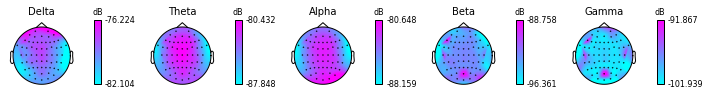

In [71]:
epochs.plot_psd_topomap(cmap="cool", outlines="head")

None

    Using multitaper spectrum estimation with 7 DPSS windows


/home/atsuya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


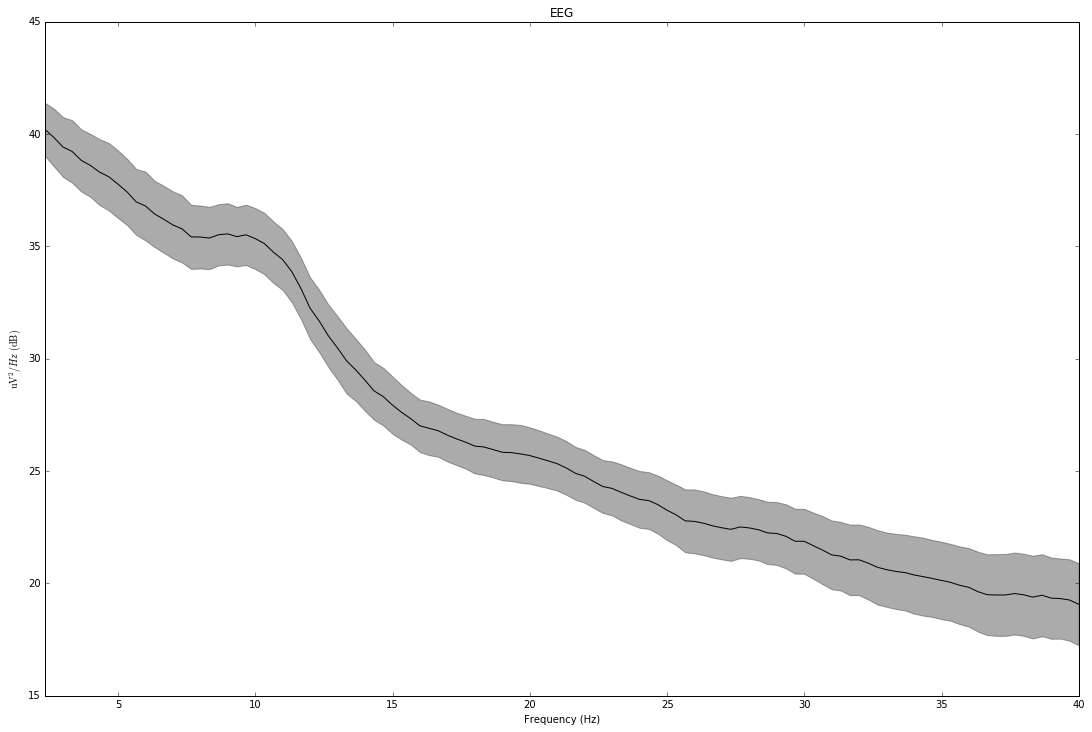

In [72]:
epochs.plot_psd(fmin=2., fmax=40.)

None

## Event Related Potentials (ERPs)

[Reference](https://martinos.org/mne/stable/auto_tutorials/plot_eeg_erp.html)

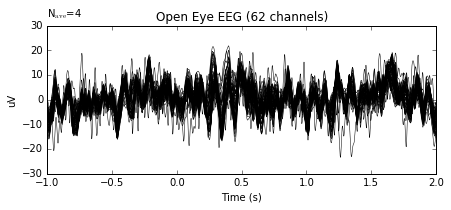

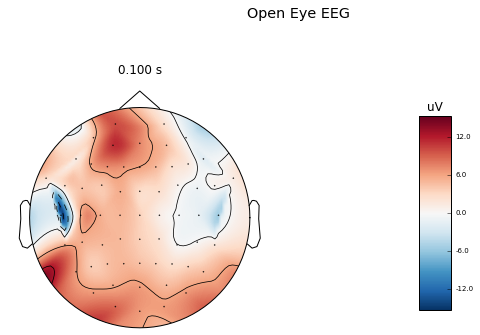

In [62]:
evoked = epochs["open"].average()

title = 'Open Eye EEG'

evoked.plot(titles=dict(eeg=title), time_unit='s')
evoked.plot_topomap(times=[0.1], size=3., title=title, time_unit='s')

None

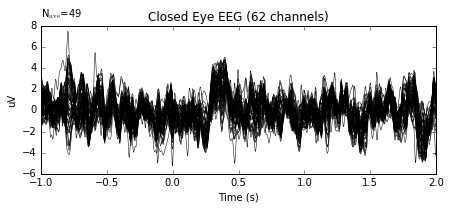

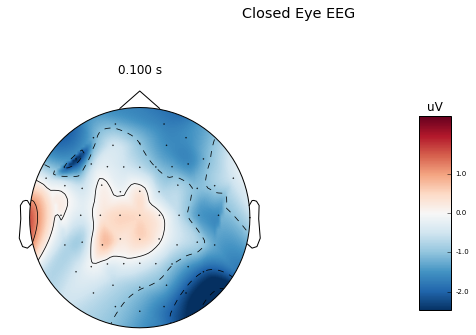

In [61]:
evoked = epochs["closed"].average()

title = 'Closed Eye EEG'

evoked.plot(titles=dict(eeg=title), time_unit='s')
evoked.plot_topomap(times=[0.1], size=3., title=title, time_unit='s')

None

---